In [54]:
import os, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings('ignore') 

In [55]:
from random import shuffle
import sys
from datetime import datetime, timedelta
import numpy as np , pandas as pd
import time
import joblib
import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from vae_conv_I_model import VariationalAutoencoderConvInterpretable as VAE_ConvI
from config import config as cfg
import utils
import write_outputs

# Define some variables

In [56]:
data_dir = './datasets/'
output_dir = './outputs/'
model_dir = './model/'
log_dir = './log/'

In [81]:
dataset_names = ['sine', 'stocks', 'air', 'energy']
percs = [2, 5, 10, 20, 100]

# dataset_names = ['sine']
# percs = [2]

In [82]:
# how many times to run each scenario
num_iters = 5

# set 10% off for validation during VAE model development; then set to 0 for final data generation
valid_perc = 0.0


# our model name
model = 'vae_conv_I'

# Utility Functions

In [83]:
# Set seed for reproducibility
def set_seeds(seed_value):   
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [84]:
def get_train_valid_split(data, valid_perc):
    N = data.shape[0]
    N_train = int(N * (1 - valid_perc))
    N_valid = N - N_train

    # shuffle data, just in case
    np.random.shuffle(data)

    # train, valid split 
    train_data = data[:N_train]
    valid_data = data[N_train:]
    return train_data, valid_data

In [85]:
def scale_train_valid_data(train_data, valid_data): 
    
    _, T, D = train_data.shape
    
    scaler = utils.MinMaxScaler_Feat_Dim( scaling_len = T, input_dim = D, upper_bound = 3.0, lower_bound = -3.0 )        
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_valid_data = scaler.transform(valid_data)
    
    return scaled_train_data, scaled_valid_data, scaler

# Main VAE Loop

In [86]:
# important hyper-parameter!!!
latent_dim = 8


# set random gen seed for reproducibiity
set_seeds(42)

main_start_time = time.time()    

for data_name in dataset_names:
    
    for p in percs:  
        
        # file name to load
        fname = f'{data_dir + data_name}_subsampled_train_perc_{p}.npz'
        
        # read data        
        loaded = np.load(fname)
        data = loaded['data']
#         print(fname, data.shape)        
        N, T, D = data.shape  
        
        
        # perform train/valid split
        train_data, valid_data = get_train_valid_split(data, valid_perc)        
        #print("train/valid shapes: ", train_data.shape, valid_data.shape)       
#         print("train/valid means: ", train_data.mean(), valid_data.mean()) 
        
        
        # scale data 
        scaled_train_data, scaled_valid_data, scaler = scale_train_valid_data(train_data, valid_data)      
        #print("train/valid shapes: ", scaled_train_data.shape, scaled_valid_data.shape)     
#         print("train/valid means : ", scaled_train_data.mean(), scaled_valid_data.mean()) 
        
        training_times = []
        for iter in range(num_iters):
            print(f"Currently running dataset = {data_name}, perc = {p}, iter = {iter}")
            
            # start timer
            start = time.time()            
            
            # ----------------------------------------------------------------------------------------------
            # Instantiate the VAE
            vae = VAE_ConvI( seq_len=T,  feat_dim = D, latent_dim = latent_dim, hidden_layer_sizes=[100, 200],  
                    # trend_poly=1, 
                    # num_gen_seas=1,
                    # custom_seas = [ (7, 1)] ,     # list of tuples of (num_of_seasons, len_per_season)
                    use_residual_conn = True
                )
                
            vae.compile(optimizer=Adam())
            # vae.summary() ; sys.exit()
            
            # ----------------------------------------------------------------------------------------------
            # Train the VAE
            early_stop_loss = 'loss'
            early_stop_callback = EarlyStopping(monitor=early_stop_loss, min_delta = 1e-1, patience=50) 
            reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)

            vae.fit(
                scaled_train_data, 
                batch_size = 32,
                epochs=1000,
                shuffle = True,
                callbacks=[early_stop_callback, reduceLR],
                verbose = 0
            )
            # ----------------------------------------------------------------------------------------------
            # stop timer and log training time 
            end = time.time()
            train_time = np.round((end - start)/60.0, 2)
            
            training_times.append({
                'model': model,
                'data': data_name, 
                'perc': p,  
                'iter': iter, 
                'train_time_in_min': train_time,                
            })            
            # ----------------------------------------------------------------------------------------------
            # Save the model 
            pref = f'{model}_{data_name}_perc_{p}_iter_{iter}_'
            vae.save(model_dir, pref)  
            
        # ----------------------------------------------------------------------------------------------        
        # Generate samples   
        # We will save samples from the last iteration 
        samples = vae.get_prior_samples(num_samples=train_data.shape[0])
        
        # inverse transform using scaler 
        samples = scaler.inverse_transform(samples)        
        
        # save to output dir
        samples_fpath = f'{model}_gen_samples_{data_name}_perc_{p}.npz'        
        np.savez_compressed(os.path.join( output_dir, samples_fpath), data=samples)
        # ----------------------------------------------------------------------------------------------        
        # log training times for the iterations
        log_df = pd.DataFrame.from_dict(training_times)
        log_file = f'{model}_{data_name}_perc_{p}_train_log.csv'
        log_df.to_csv(log_dir + log_file, index=False)
            

end = time.time()
elapsed_time = np.round((end - main_start_time)/60.0, 2)
print(f"All done in {elapsed_time} minutes!")  

Currently running = air, perc = 2, iter = 0
Currently running = air, perc = 2, iter = 1
Currently running = air, perc = 2, iter = 2
Currently running = air, perc = 2, iter = 3
Currently running = air, perc = 2, iter = 4
Currently running = air, perc = 5, iter = 0
Currently running = air, perc = 5, iter = 1
Currently running = air, perc = 5, iter = 2
Currently running = air, perc = 5, iter = 3
Currently running = air, perc = 5, iter = 4
Currently running = air, perc = 10, iter = 0
Currently running = air, perc = 10, iter = 1
Currently running = air, perc = 10, iter = 2
Currently running = air, perc = 10, iter = 3
Currently running = air, perc = 10, iter = 4
Currently running = air, perc = 20, iter = 0
Currently running = air, perc = 20, iter = 1
Currently running = air, perc = 20, iter = 2
Currently running = air, perc = 20, iter = 3
Currently running = air, perc = 20, iter = 4
Currently running = air, perc = 100, iter = 0
Currently running = air, perc = 100, iter = 1
Currently running 

# Load generated data for Inspection

In [87]:
test_data = 'stocks'
test_perc = 5
test_iter = 0

sample_file_name = output_dir + f'vae_conv_I_gen_samples_{test_data}_perc_{test_perc}.npz'
loaded = np.load(sample_file_name)
gen_data = loaded['data']
print(gen_data.shape)

print("generated mean : ", gen_data.mean()) 

(160, 24, 6)
generated mean :  213292.78819274696


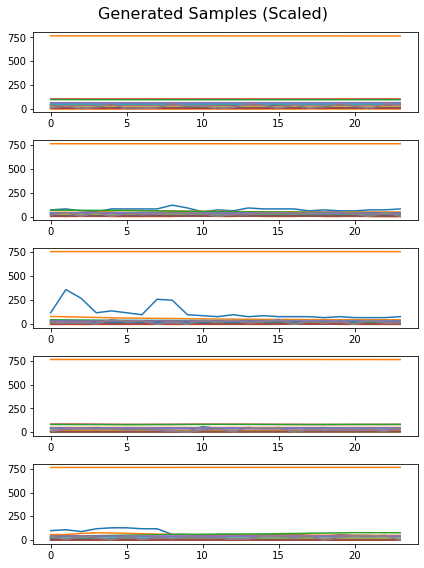

In [88]:
utils.plot_samples(data, n=5)